In [1]:
%matplotlib inline

In [2]:
import json

import numpy as np
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image

Using TensorFlow backend.


For tensorflow it should be `channels_first`

In [3]:
from keras import backend as K
K.image_data_format()

'channels_first'

## Preparation

Get the clases of the model

Note: cache files are located under `~/.keras`

In [4]:
FILES_PATH = 'http://files.fast.ai/models/'
CLASS_FILE='imagenet_class_index.json'

In [5]:
fpath = get_file(CLASS_FILE, FILES_PATH + CLASS_FILE, cache_subdir='models')

In [6]:
with open(fpath) as f:
    class_dict = json.load(f)

classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [7]:
classes[:5]

['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']

Get the pretrained weights

In [8]:
weights_fpath = get_file('vgg16.h5', FILES_PATH + 'vgg16.h5', cache_subdir='models')

## Model creation

Creating the model involves creating the model architecture, and then loading the model weights into that architecture. We will start by defining the basic pieces of the VGG architecture.

VGG has just one type of convolutional block, and one type of fully connected ('dense') block. Here's the convolutional block definition:

In [9]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

In [10]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

When the VGG model was trained in 2014, the creators subtracted the average of each of the three (R,G,B) channels first, so that the data for each channel had a mean of zero. Furthermore, their software that expected the channels to be in B,G,R order, whereas Python by default uses R,G,B. We need to preprocess our data to make these two changes, so that it is compatible with the VGG model:

- Convolution layers are for finding patterns in images
- Dense (fully connected) layers are for combining patterns across an image


In [11]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3, 1, 1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

In [12]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3, 224, 224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

Create model and load pretrained weights

In [13]:
model = VGG_16()

In [14]:
model.load_weights(weights_fpath)

## Make predictions

Keras provides functionality to create batches of data from directories containing images; all we have to do is to define the size to resize the images to, what type of labels to create, whether to randomly shuffle the images, and how many images to include in each batch. We use this little wrapper to define some helpful defaults appropriate for imagenet data:

In [15]:
batch_size = 4

In [53]:
def get_batches(dirpath, gen=image.ImageDataGenerator(), shuffle=True, batch_size=8, class_mode='categorical'):
    return gen.flow_from_directory(dirpath, target_size=(224,224), class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [17]:
batches = get_batches('./data/train', batch_size=batch_size)

imgs, labels = next(batches)

Found 22778 images belonging to 2 classes.


In [18]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i, idx in enumerate(idxs):
        print ('  {}: {:.4f}'.format(classes[idx], preds[i, idx]))

In [19]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes: ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']
First 5 probabilities: [  3.30755611e-05   2.58079108e-05   5.74209698e-05   1.42809740e-05
   8.09883204e-06]

Predictions prob/class: 
  carousel: 0.4155
  boathouse: 0.0811
  conch: 0.1803
  lynx: 0.1659


In [20]:
def plot(img):
    img = np.rollaxis(img, 0, 3).astype(np.uint8)
    plt.imshow(img)

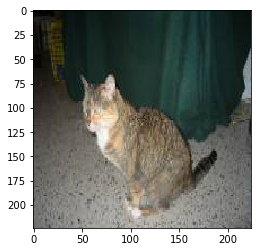

In [21]:
plot(imgs[2])

## Finetune

In [22]:
batch_size=64

In [23]:
train_batches = get_batches('./data/train', batch_size=batch_size)

Found 22778 images belonging to 2 classes.


In [25]:
val_batches = get_batches('./data/valid', batch_size=batch_size)

Found 2222 images belonging to 2 classes.


Replace the last layer of the model with a Dense (fully connected) layer of num neurons.
            Will also lock the weights of all layers except the new layer so that we only learn
            weights for the last layer in subsequent training.

In [26]:
model.pop()
for layer in model.layers:
    layer.trainable=False

In [27]:
model.add(Dense(train_batches.num_class, activation='softmax'))

Configures the model for training.

In [28]:
lr=0.001

In [29]:
model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
classes = list(iter(train_batches.class_indices))

In [31]:
classes

['cat', 'dog']

Actual training

In [ ]:
nb_epoch = 1

DONT RUN THIS ONE IF LOAD FINETUNED WEIGTHS - SKIP TO NEXT SECTION

In [33]:
model.fit_generator(train_batches, steps_per_epoch=train_batches.samples // train_batches.batch_size, 
                    validation_data=val_batches, validation_steps=val_batches.samples//val_batches.batch_size,
                    epochs=nb_epoch)

Epoch 1/1
355/355 [==============================] - 481s - loss: 0.2907 - acc: 0.8926 - val_loss: 0.2305 - val_acc: 0.9104


Save weights

In [34]:
model.save_weights('weights.h5')

### manual test

Load saved weights

In [ ]:
model.load_weights('weights.h5')

In [35]:
batch_size = 4

In [37]:
manual_batches = get_batches('./data/train', batch_size=batch_size)

imgs, labels = next(manual_batches)

Found 22778 images belonging to 2 classes.


In [38]:
pred_batch(imgs)

Shape: (4, 2)
First 5 classes: ['cat', 'dog']
First 5 probabilities: [ 0.81106949  0.18893045]

Predictions prob/class: 
  cat: 0.8111
  cat: 0.9996
  dog: 0.9867
  cat: 0.9372


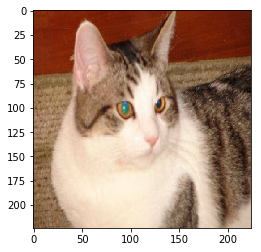

In [39]:
plot(imgs[1])

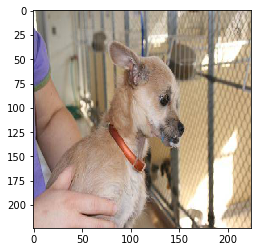

In [40]:
plot(imgs[2])

### real test

how many correct from validation

In [41]:
val_batches.samples

2222

In [89]:
batch_size = 11

In [90]:
val_batches = get_batches('./data/valid', shuffle=False, batch_size=batch_size, class_mode=None)

Found 2222 images belonging to 2 classes.


In [91]:
expected_labels = val_batches.classes

In [92]:
expected_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [93]:
val_batches.samples

2222

In [94]:
valid_probs = model.predict_generator(val_batches, val_batches.samples // batch_size)

In [95]:
valid_probs.shape

(2222, 2)

In [96]:
my_predictions = valid_probs[:,0]
my_labels = np.round(1 - my_predictions)

In [97]:
cm = confusion_matrix(expected_labels, my_labels)

In [98]:
cm

array([[ 965,  146],
       [  54, 1057]])

### Generate submission

In [99]:
test_path = './data/test'

In [101]:
batch_size = 50

In [102]:
test_batches = get_batches(test_path, shuffle=False, batch_size=batch_size, class_mode=None)

Found 12500 images belonging to 1 classes.


In [103]:
test_batches.samples

12500

In [104]:
preds = model.predict_generator(test_batches, test_batches.samples // batch_size)

In [105]:
preds.shape

(12500, 2)

In [106]:
preds

array([[  9.98292625e-01,   1.70738692e-03],
       [  6.92508092e-06,   9.99993086e-01],
       [  7.25166698e-04,   9.99274790e-01],
       ..., 
       [  1.85147941e-01,   8.14852059e-01],
       [  8.61382037e-02,   9.13861811e-01],
       [  3.21421167e-03,   9.96785760e-01]], dtype=float32)

In [107]:
filenames = test_batches.filenames

In [108]:
len(filenames)

12500

In [109]:
filenames[:10]

['unknown/2957.jpg',
 'unknown/11706.jpg',
 'unknown/10629.jpg',
 'unknown/9810.jpg',
 'unknown/9834.jpg',
 'unknown/5308.jpg',
 'unknown/2850.jpg',
 'unknown/6998.jpg',
 'unknown/6901.jpg',
 'unknown/7008.jpg']

In [110]:
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [111]:
ids

array([ 2957, 11706, 10629, ...,  2885,  8923,  8897])

In [112]:
import pandas as pd

In [115]:
sub = pd.read_csv('data/sample_submission.csv')

In [116]:
sub.head()

,id,label
0,1,0.5
1,2,0.5
2,3,0.5
3,4,0.5
4,5,0.5


In [117]:
sub.id = ids

In [118]:
isdog = preds[:,1]

In [119]:
sub.label = isdog

In [120]:
sub.head()

,id,label
0,2957,0.001707
1,11706,0.999993
2,10629,0.999275
3,9810,0.212310
4,9834,0.002853


In [121]:
sub.to_csv('sub.csv', index=None)